In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date

('2017-08-23')

# Exploratory Climate Analysis

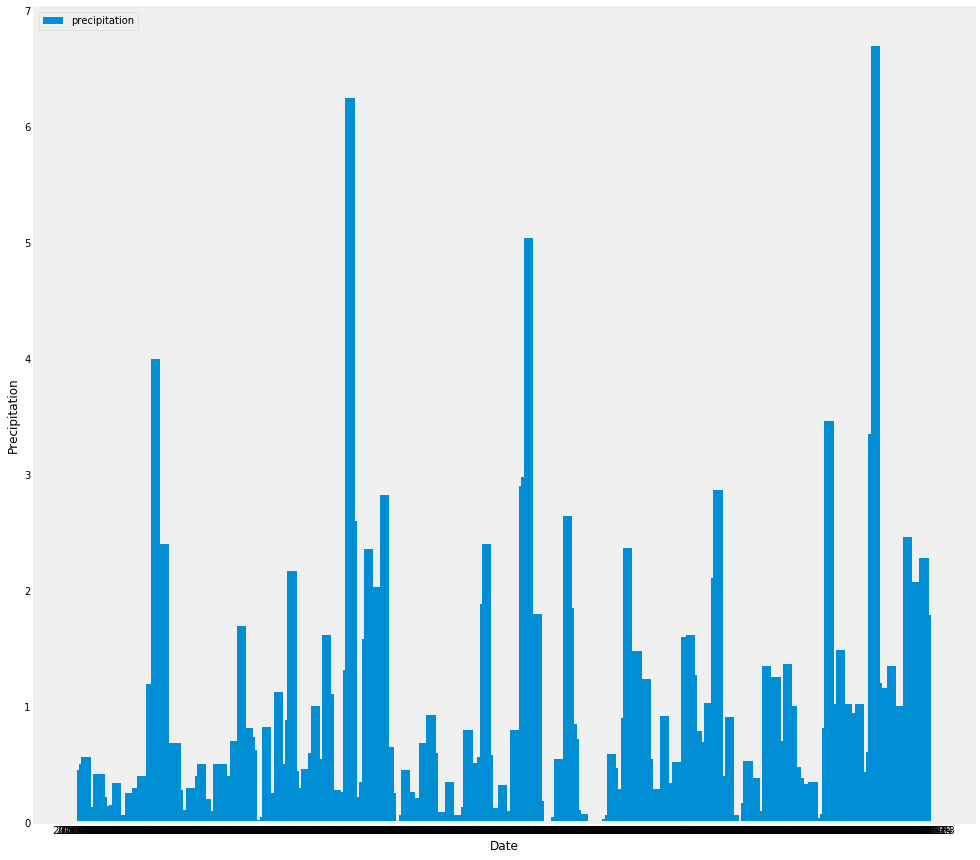

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#data = session.query(Measurement).first()
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
#for c in columns:
#    print(c['name'], c["type"])

#engine.execute('SELECT * FROM Measurement order by date desc LIMIT 5').fetchall()

# Calculate the date 1 year ago from today
max_date = session.query(func.max(Measurement.date)).one()
year_ago = dt.datetime.strptime(max_date[0],'%Y-%m-%d').date() - dt.timedelta(days=365)
#year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

#year_ago = dt.date.today() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,Measurement.station,Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data)
df.set_index('date',inplace=True)
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

fig,ax = plt.subplots(figsize=(15,15))
x = np.arange(len(df.index.values))
ax.bar(df.index.values,df['prcp'],width=4)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.grid()
ax.legend(['precipitation'],loc='best')
#plt.xticks(x,df.index.values)
plt.show()
# Rotate the xticks for the dates


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp,tobs
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


In [13]:
# How many stations are available in this dataset?
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

station_count = session.query(func.count(Station.station)).first()
station_count

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


(9)

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stats = session.query(Measurement.station, func.count(Measurement.station),
                     func.avg(Measurement.prcp), func.min(Measurement.prcp),
                     func.max(Measurement.prcp)).\
                     group_by(Measurement.station).all()
stats

[('USC00511918', 1979, 0.04797101449275366, 0.0, 4.0),
 ('USC00513117', 2709, 0.14192136498516264, 0.0, 7.65),
 ('USC00514830', 2202, 0.12105833763551899, 0.0, 11.53),
 ('USC00516128', 2612, 0.4299879227053122, 0.0, 8.06),
 ('USC00517948', 1372, 0.06360175695461204, 0.0, 2.8),
 ('USC00518838', 511, 0.20722222222222236, 0.0, 6.3),
 ('USC00519281', 2772, 0.2123520923520915, 0.0, 9.64),
 ('USC00519397', 2724, 0.0490204841713224, 0.0, 4.2),
 ('USC00519523', 2669, 0.11496111975116619, 0.0, 6.38)]

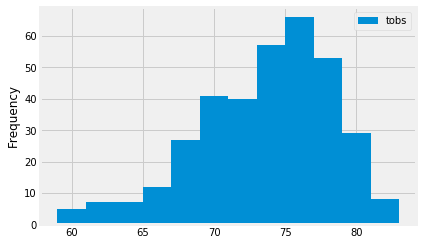

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


station_max = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

prcp_max_data = session.query(Measurement.date,Measurement.station,Measurement.prcp,Measurement.tobs).\
    filter(Measurement.station == station_max.station).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date.desc()).all()


df_max = pd.DataFrame(prcp_max_data)
plt.hist(df_max['tobs'], bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'],loc='upper right')
plt.show()

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tdata = calc_temps('2016-08-23','2017-08-23')


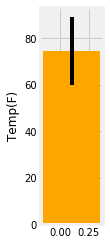

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [tdata[0][0],tdata[0][2]]
fig,ax= plt.subplots(figsize=(1,4))
ax.bar(0.1,width=0.5,height=tdata[0][1],color='orange',yerr=np.std(error))
ax.grid()
ax.set_ylabel('Temp(F)')
plt.grid()

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
base_date = dt.date(2017,1,1)
date_list = [base_date - dt.timedelta(days=x) for x in range(0, 7)]
formated = [x.strftime('%m-%d') for x in date_list]
normals = [daily_normals(i) for i in formated]

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df_list = []
for x in range(0,len(normals)-1):
    frame_dict = {}
    frame_dict['date'] = date_list[x].strftime('%Y-%m-%d')
    frame_dict['tmin'] = normals[x][0][0]
    frame_dict['tavg'] = normals[x][0][1]
    frame_dict['tmax'] = normals[x][0][2]
    df_list.append(frame_dict)
    
df_trips = pd.DataFrame(df_list)
df_trips.set_index('date',inplace=True)
df_trips.head()

,tavg,tmax,tmin
date,,,
2017-01-01,69.153846,77.0,62.0
2016-12-31,68.279070,77.0,56.0
2016-12-30,69.863636,76.0,63.0
2016-12-29,70.291667,78.0,57.0
2016-12-28,70.520833,77.0,62.0


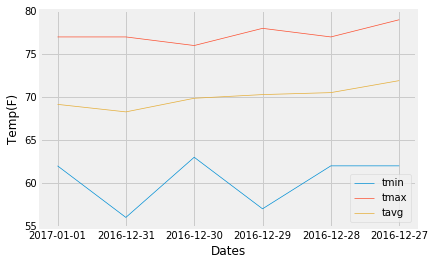

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
plt.plot(df_trips.index.values,df_trips['tmin'],linewidth=0.7,label='tmin')
plt.plot(df_trips.index.values,df_trips['tmax'],linewidth=0.7,label='tmax')
plt.plot(df_trips.index.values,df_trips['tavg'],linewidth=0.7,label='tavg')
plt.xlabel('Dates')
plt.ylabel('Temp(F)')
plt.legend()
plt.show()